Задача: Выполнить классификацию изображений на наборе notMNIST_small.

In [6]:
from keras import models
from keras import optimizers
from keras import layers
from keras.metrics import AUC
from matplotlib import pyplot as plt
import numpy as np
import tarfile
import os, shutil
import cv2
import random

In [28]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras.initializers import GlorotUniform

In [7]:
# Устанавливаем seed для всех библиотек
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [8]:
base_dir = './notMNIST_small'
os.listdir(f'{base_dir}/A')[:5]  

['MDEtMDEtMDAudHRm.png',
 'MDRiXzA4LnR0Zg==.png',
 'MjAwcHJvb2Ztb29uc2hpbmUgcmVtaXgudHRm.png',
 'MlJlYmVsc0RldXgtQmxhY2sub3Rm.png',
 'MlRvb24gU2hhZG93LnR0Zg==.png']

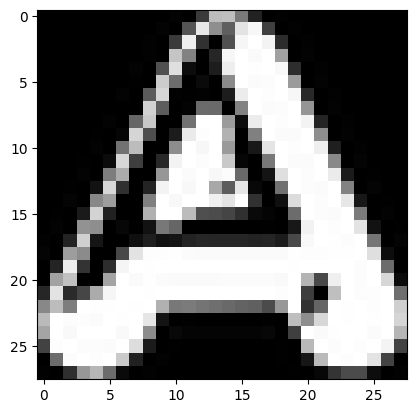

In [9]:
img = cv2.imread("./notMNIST_small/A/Q2FwdGFpbiBTaGluZXIudHRm.png")    # смотрим вид изображения
plt.imshow(img)
plt.show()

In [10]:
folders = 'ABCDEFGHIJ'    # имеющиеся буквы
for folder in folders:
  print(f"total {folder} images: {len(os.listdir(f'{base_dir}/{folder}'))}")    # смотрим количество данных каждого класса

total A images: 1873
total B images: 1873
total C images: 1873
total D images: 1873
total E images: 1873
total F images: 1873
total G images: 1872
total H images: 1872
total I images: 1872
total J images: 1872


In [11]:
imgs = []
labels = []
for folder in folders:    # каждая папка с буквами
  for img in os.listdir(base_dir + f"/{folder}"):   # каждая буква
    if img.endswith('.png'):    # только png
      try:    # если удалось прочитать 
        #imgs.append(cv2.imread(base_dir + f"/{folder}/{img}")[:, :, 0])   # добавляем изображение
        if not np.all(cv2.imread(base_dir + f"/{folder}/{img}")[:, :, 0] ==cv2.imread(base_dir + f"/{folder}/{img}")[:, :, 0][0]):
            imgs.append(cv2.imread(base_dir + f"/{folder}/{img}")[:, :, 0])
            labels.append(folder)   # добавляем метку класса
      except:   # если возникла ошибка при чтении
        print(base_dir + f"/{folder}/{img}")     # выводим название изображение, которое не удалось прочитать
        continue
imgs = np.array(imgs).astype('float32')/255.    # масштабируем признаки

./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


In [12]:
def to_categorical(labels):
  """
  This function convert the latter into a categorical shape(view)
  labels: this param consists of the letters which will convert
  Example: labels -> ['A', 'B'] -> [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]] 
  """
  categories = 'ABCDEFGHIJ'
  new_labels = np.zeros(shape=(len(labels), len(categories)))
  for i, label in enumerate(labels):
    new_labels[i][categories.find(label)] = 1 
  return new_labels

A
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


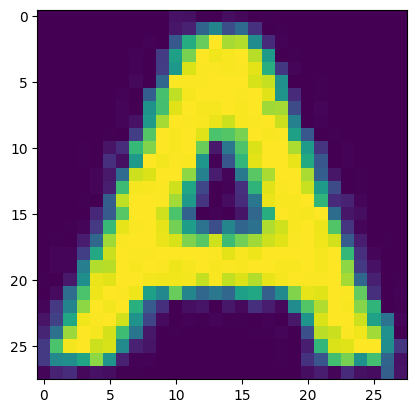

In [13]:
print(labels[0])    # выводим пример изображения с меткой
labels = to_categorical(labels)
plt.imshow(imgs[0])
print(labels[0])

In [14]:
indices = np.arange(labels.shape[0])    # перемешиваем данные
np.random.shuffle(indices)
imgs = imgs[indices]
labels = labels[indices]

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


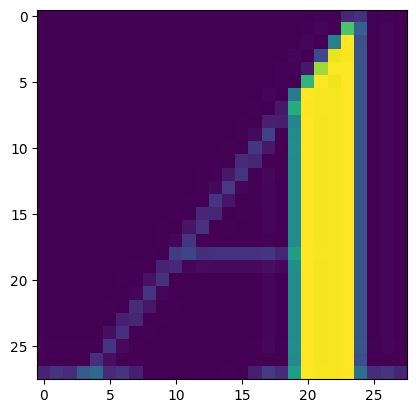

In [10]:
plt.imshow(imgs[0])
print(labels[0])

In [15]:
print("Images shape: ", imgs.shape)   # выводим размеры датасета
print("Labels shape: ", labels.shape)

Images shape:  (18442, 28, 28)
Labels shape:  (18442, 10)


In [16]:
# разбиваем на тестовую и тренировочную выборку
test_imgs = imgs[:500]
test_labels = labels[:500]
train_imgs = imgs[500:]
train_labels = labels[500:]
print("Train images shape: ", train_imgs.shape)
print("Test images shape: ", test_imgs.shape)
print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train images shape:  (17942, 28, 28)
Test images shape:  (500, 28, 28)
Train labels shape:  (17942, 10)
Test labels shape:  (500, 10)


In [17]:
# Добавляем измерение для канала (grayscale изображения)
train_images = np.expand_dims(train_imgs, axis=-1)  # Форма: (17942, 28, 28, 1)
test_images = np.expand_dims(test_imgs, axis=-1)    # Форма: (500, 28, 28, 1)

Обучим и протестируем несколько вариантов сетей.

1. Без Batch Normalization

In [20]:
initializer = GlorotUniform(seed=seed)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_initializer=initializer),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializer),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dropout(0.5, seed=seed),  # Dropout для регуляризации
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # Выходной слой для классификации (10 классов)
])

In [21]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
epochs = 20
batch_size = 32

history = model.fit(
    train_images, train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test_images, test_labels)
)

Epoch 1/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5083 - loss: 1.3797 - val_accuracy: 0.7320 - val_loss: 0.6514
Epoch 2/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7410 - loss: 0.7196 - val_accuracy: 0.7520 - val_loss: 0.5648
Epoch 3/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7663 - loss: 0.6278 - val_accuracy: 0.7740 - val_loss: 0.5283
Epoch 4/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7795 - loss: 0.5820 - val_accuracy: 0.7980 - val_loss: 0.4927
Epoch 5/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7851 - loss: 0.5462 - val_accuracy: 0.7980 - val_loss: 0.4857
Epoch 6/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8009 - loss: 0.5212 - val_accuracy: 0.7900 - val_loss: 0.4824
Epoch 7/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8061 - loss: 0.4917 - val_accuracy: 0.8060 - val_loss: 0.4523
Epoch 8/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8101 - loss: 0.4695 - val_accuracy: 0.

In [23]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8302 - loss: 0.3917
Test accuracy: 0.8199999928474426


2. С использованием Batch Normalization

In [24]:
initializer = GlorotUniform(seed=seed)
# Создание модели
model = Sequential([
    # Первый сверточный блок
    Conv2D(32, (3, 3), kernel_initializer=initializer),  # Сверточный слой
    BatchNormalization(),  # Batch Normalization
    Activation('relu'),  # Активационная функция
    MaxPooling2D((2, 2)),  # Слой подвыборки

    # Второй сверточный блок
    Conv2D(64, (3, 3), kernel_initializer=initializer),  # Сверточный слой
    BatchNormalization(),  # Batch Normalization
    Activation('relu'),  # Активационная функция
    MaxPooling2D((2, 2)),  # Слой подвыборки

    # Третий сверточный блок
    Conv2D(128, (3, 3), kernel_initializer=initializer),  # Сверточный слой
    BatchNormalization(),  # Batch Normalization
    Activation('relu'),  # Активационная функция
    MaxPooling2D((2, 2)),  # Слой подвыборки

    # Полносвязная часть
    Flatten(),  # Преобразование в одномерный вектор
    Dense(128),  # Полносвязный слой
    BatchNormalization(),  # Batch Normalization
    Activation('relu'),  # Активационная функция
    Dropout(0.5, seed=seed),  # Dropout для регуляризации

    # Выходной слой
    Dense(10),  # Полносвязный слой для классификации (10 классов)
    Activation('softmax')  # Активационная функция для многоклассовой классификации
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


epochs = 20
batch_size = 32

history = model.fit(
    train_images, train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test_images, test_labels)
)

Epoch 1/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6013 - loss: 1.1679 - val_accuracy: 0.7440 - val_loss: 0.6464
Epoch 2/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7732 - loss: 0.6294 - val_accuracy: 0.7880 - val_loss: 0.5161
Epoch 3/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7954 - loss: 0.5424 - val_accuracy: 0.7880 - val_loss: 0.4881
Epoch 4/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8141 - loss: 0.4940 - val_accuracy: 0.8060 - val_loss: 0.4964
Epoch 5/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8268 - loss: 0.4475 - val_accuracy: 0.7980 - val_loss: 0.4977
Epoch 6/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8380 - loss: 0.4165 - val_accuracy: 0.8120 - val_loss: 0.4880
Epoch 7/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8437 - loss: 0.3896 - val_accuracy: 0.8140 - val_loss: 0.4759
Epoch 8/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8569 - loss: 0.3544 - val_acc

In [25]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8420 - loss: 0.5382
Test accuracy: 0.8259999752044678


3. С использованием Batch Normalization и callbacks.

In [26]:
initializer = GlorotUniform(seed=seed)

# Создание модели
model = Sequential([
    # Первый сверточный блок
    Conv2D(32, (3, 3), kernel_initializer=initializer),  # Сверточный слой
    BatchNormalization(),  # Batch Normalization
    Activation('relu'),  # Активационная функция
    MaxPooling2D((2, 2)),  # Слой подвыборки

    # Второй сверточный блок
    Conv2D(64, (3, 3), kernel_initializer=initializer),  # Сверточный слой
    BatchNormalization(),  # Batch Normalization
    Activation('relu'),  # Активационная функция
    MaxPooling2D((2, 2)),  # Слой подвыборки

    # Третий сверточный блок
    Conv2D(128, (3, 3), kernel_initializer=initializer),  # Сверточный слой
    BatchNormalization(),  # Batch Normalization
    Activation('relu'),  # Активационная функция
    MaxPooling2D((2, 2)),  # Слой подвыборки

    # Полносвязная часть
    Flatten(),  # Преобразование в одномерный вектор
    Dense(128),  # Полносвязный слой
    BatchNormalization(),  # Batch Normalization
    Activation('relu'),  # Активационная функция
    Dropout(0.5, seed=seed),  # Dropout для регуляризации

    # Выходной слой
    Dense(10),  # Полносвязный слой для классификации (10 классов)
    Activation('softmax')  # Активационная функция для многоклассовой классификации
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback'и
# 1. ModelCheckpoint: сохраняет лучшую модель
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Путь для сохранения модели
    monitor='val_accuracy',    # Мониторим точность на валидации
    save_best_only=True,       # Сохраняем только лучшую модель
    mode='max',                # Режим 'max' для точности
    verbose=1
)

# 2. EarlyStopping: останавливает обучение, если нет улучшений
early_stopping = EarlyStopping(
    monitor='val_accuracy',    # Мониторим точность на валидации
    patience=5,                # Количество эпох без улучшений перед остановкой
    restore_best_weights=True, # Восстанавливает веса лучшей модели
    mode='max',
    verbose=1
)

# 3. ReduceLROnPlateau: уменьшает learning rate, если нет улучшений
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',    # Мониторим точность на валидации
    factor=0.2,               # Уменьшаем learning rate в 5 раз
    patience=3,               # Количество эпох без улучшений перед уменьшением
    mode='max',
    verbose=1
)

# 4. TensorBoard: логирование для визуализации
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Список callback'ов
callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

# Обучение модели
history = model.fit(
    train_images, train_labels,
    batch_size=32,
    epochs=50,  # Увеличиваем количество эпох, так как EarlyStopping может остановить обучение раньше
    validation_data=(test_images, test_labels),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
558/561 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5988 - loss: 1.2021
Epoch 1: val_accuracy improved from -inf to 0.72800, saving model to best_model.keras
561/561 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5995 - loss: 1.1999 - val_accuracy: 0.7280 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 2/50
559/561 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7713 - loss: 0.6314
Epoch 2: val_accuracy improved from 0.72800 to 0.76400, saving model to best_model.keras
561/561 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7713 - loss: 0.6313 - val_accuracy: 0.7640 - val_loss: 0.5286 - learning_rate: 0.0010
Epoch 3/50
560/561 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7946 - loss: 0.5452
Epoch 3: val_accuracy improved from 0.76400 to 0.79400, saving model to best_model.keras
561/561 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7946 - loss: 0.5452 - val_accuracy: 0.7940 - val_loss: 0.4702 - learning_rate: 0.0010
Epoch 4/50
558/561 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

In [27]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8436 - loss: 0.4306
Test accuracy: 0.8379999995231628


4. Изменена структура сети (размерность слоев)

In [29]:

from tensorflow.keras.regularizers import l2

# Инициализатор с фиксированным seed
seed = 42
initializer = GlorotUniform(seed=seed)

# Создание модели
model = Sequential([
    # Первый блок сверток
    Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25, seed=seed),

    # Второй блок сверток
    Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25, seed=seed),

    # Третий блок сверток
    Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25, seed=seed),

    # Четвертый блок сверток
    Conv2D(256, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    GlobalAveragePooling2D(),  # Глобальный средний пулинг вместо Flatten
    Dropout(0.5, seed=seed),

    # Полносвязный слой
    Dense(256, kernel_initializer=initializer, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5, seed=seed),

    # Выходной слой
    Dense(10, kernel_initializer=initializer),  # 10 классов
    Activation('softmax')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])





In [30]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Callback'и
# 1. ModelCheckpoint: сохраняет лучшую модель
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Путь для сохранения модели
    monitor='val_accuracy',    # Мониторим точность на валидации
    save_best_only=True,       # Сохраняем только лучшую модель
    mode='max',                # Режим 'max' для точности
    verbose=1
)

# 2. EarlyStopping: останавливает обучение, если нет улучшений
early_stopping = EarlyStopping(
    monitor='val_accuracy',    # Мониторим точность на валидации
    patience=5,                # Количество эпох без улучшений перед остановкой
    restore_best_weights=True, # Восстанавливает веса лучшей модели
    mode='max',
    verbose=1
)

# 3. ReduceLROnPlateau: уменьшает learning rate, если нет улучшений
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',    # Мониторим точность на валидации
    factor=0.2,               # Уменьшаем learning rate в 5 раз
    patience=3,               # Количество эпох без улучшений перед уменьшением
    mode='max',
    verbose=1
)

# 4. TensorBoard: логирование для визуализации
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Список callback'ов
callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

# Обучение модели
history = model.fit(
    train_images, train_labels,
    batch_size=64,
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=callbacks
)

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6264 - loss: 2.2331
Epoch 1: val_accuracy improved from -inf to 0.15000, saving model to best_model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 45s 136ms/step - accuracy: 0.6270 - loss: 2.2311 - val_accuracy: 0.1500 - val_loss: 5.9405 - learning_rate: 0.0010
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9098 - loss: 1.1137
Epoch 2: val_accuracy improved from 0.15000 to 0.91600, saving model to best_model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - accuracy: 0.9098 - loss: 1.1134 - val_accuracy: 0.9160 - val_loss: 0.9139 - learning_rate: 0.0010
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9237 - loss: 0.8425
Epoch 3: val_accuracy did not improve from 0.91600
281/281 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - accuracy: 0.9237 - loss: 0.8423 - val_accuracy: 0.9120 - val_loss: 0.7240 - learning_rate: 0.0010
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9252 - los

In [31]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9698 - loss: 0.2152
Test accuracy: 0.972000002861023


В ходе работы обучены несколько разлиных моделей. Сначала обучены несколько моделей, состоящих из 3 сверточных слоев, а после структура усложнена с целью получить наиболее высокие метрики. Использовался GlorotUniform для одинаковой инлизициаации весов различных моделей.
1. В первой части работы:
    Лучшее полученное значение accuracy: 0.862 (С использованием Batch Normalization и callbacks). Добавление BN в структуру модели (вариант 2) незначительно улудшило метрики в сравнении с первым случаем (на 0,5%).
    
2. Для более сложной модели, состоящей из 4 сверточных и 1 полносвязного слоев, метрика accuracy составила 0.972.